In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


### Number of Cores 

In [2]:
# number of cores
max_iters = [1, 2, 3, 4, 5]

### Training 

In [3]:
import copy
import time
from tqdm import tqdm

from func import innerConeAlignedCosine

def pipeline(reg, optmodel, loader_train, loader_test):
    elapseds, regrets = [], []
    for max_iter in max_iters:
        print("Max Iter:", max_iter)
        # set random seed
        np.random.seed(42)
        torch.manual_seed(42)
        # train
        time.sleep(1)
        e, r = trainingProcess(reg, optmodel, max_iter, loader_train, loader_test)
        elapseds.append(e)
        regrets.append(r)
        print()
    return elapseds, regrets


def trainingProcess(reg, optmodel, max_iter, loader_train, loader_test):
    # copy predictor
    reg = copy.deepcopy(reg)
    # init loss
    ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", max_iter=max_iter)
    # train
    elapsed = train(reg, ca_cos, loader_train)
    # test
    regret = pyepo.metric.regret(reg, optmodel, loader_test)
    # print
    time.sleep(1)
    print("Test Regret: {:.4f}%".format(regret*100))
    print("Test Elapsed Time: {:.2f} Sec".format(elapsed))
    return elapsed, regret

        
def train(reg, loss_func, dataloader):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)
    # training
    tbar = tqdm(range(10))
    tick = time.time()
    for epoch in tbar:
        for data in dataloader:
            # forward pass
            x, _, _, t_ctr = data
            # predict
            cp = reg(x)
            # loss
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tbar.set_description("Loss: {:8.4f}".format(loss.item()))
    # record time
    tock = time.time()
    elapsed = tock - tick
    return elapsed

### Plot

In [4]:
from matplotlib import pyplot as plt
import tol_colors as tc

def plot(max_iters, elapseds, regrets, title):
    # color map
    cset =  tc.tol_cset('light')
    # time
    fig = plt.figure(figsize=(16,8))
    plt.plot(max_iters, elapseds, marker="o", linestyle="--", markersize=10, lw=5, color=cset.orange)
    plt.xlabel("Max Iters", fontsize=36)
    plt.ylabel("Runtime (Sec)", fontsize=36)
    plt.xticks(ticks=max_iters, fontsize=28)
    plt.yticks(fontsize=28)
    plt.title("Training Time on " + title, fontsize=36)
    plt.show()
    # regret
    fig = plt.figure(figsize=(16,8))
    plt.plot(max_iters, regrets, marker="o", linestyle="--", markersize=10, lw=5, color=cset.light_blue)
    plt.xlabel("Max Iters", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.xticks(ticks=max_iters, fontsize=28)
    plt.yticks(fontsize=28)
    plt.title("Test Regret on " + title, fontsize=36)
    plt.show()

### Shortest Path

In [5]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=42)

In [6]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 4.129921459235217
(0, 5)
(5, 6)
(6, 11)
(11, 16)
(16, 17)
(17, 18)
(18, 19)
(19, 24)


In [7]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 384.73it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 823.99it/s]


In [8]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [9]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out
    
# init model
reg = LinearRegression()

In [10]:
elapseds, regrets = pipeline(reg, optmodel, loader_train, loader_test)

Max Iter: 1
Num of cores: 1


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]D:\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Loss:  -0.9384: 100%|██████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.20s/it]


Test Regret: 9.5702%
Test Elapsed Time: 62.04 Sec

Max Iter: 2
Num of cores: 1


Loss:  -0.8576: 100%|██████████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.13s/it]


Test Regret: 8.5107%
Test Elapsed Time: 61.28 Sec

Max Iter: 3
Num of cores: 1


Loss:  -0.9300: 100%|██████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.10s/it]


Test Regret: 8.0209%
Test Elapsed Time: 60.99 Sec

Max Iter: 4
Num of cores: 1


Loss:  -0.9930: 100%|██████████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.15s/it]


Test Regret: 8.0474%
Test Elapsed Time: 61.51 Sec

Max Iter: 5
Num of cores: 1


Loss:  -0.9981: 100%|██████████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.13s/it]


Test Regret: 8.4813%
Test Elapsed Time: 61.30 Sec



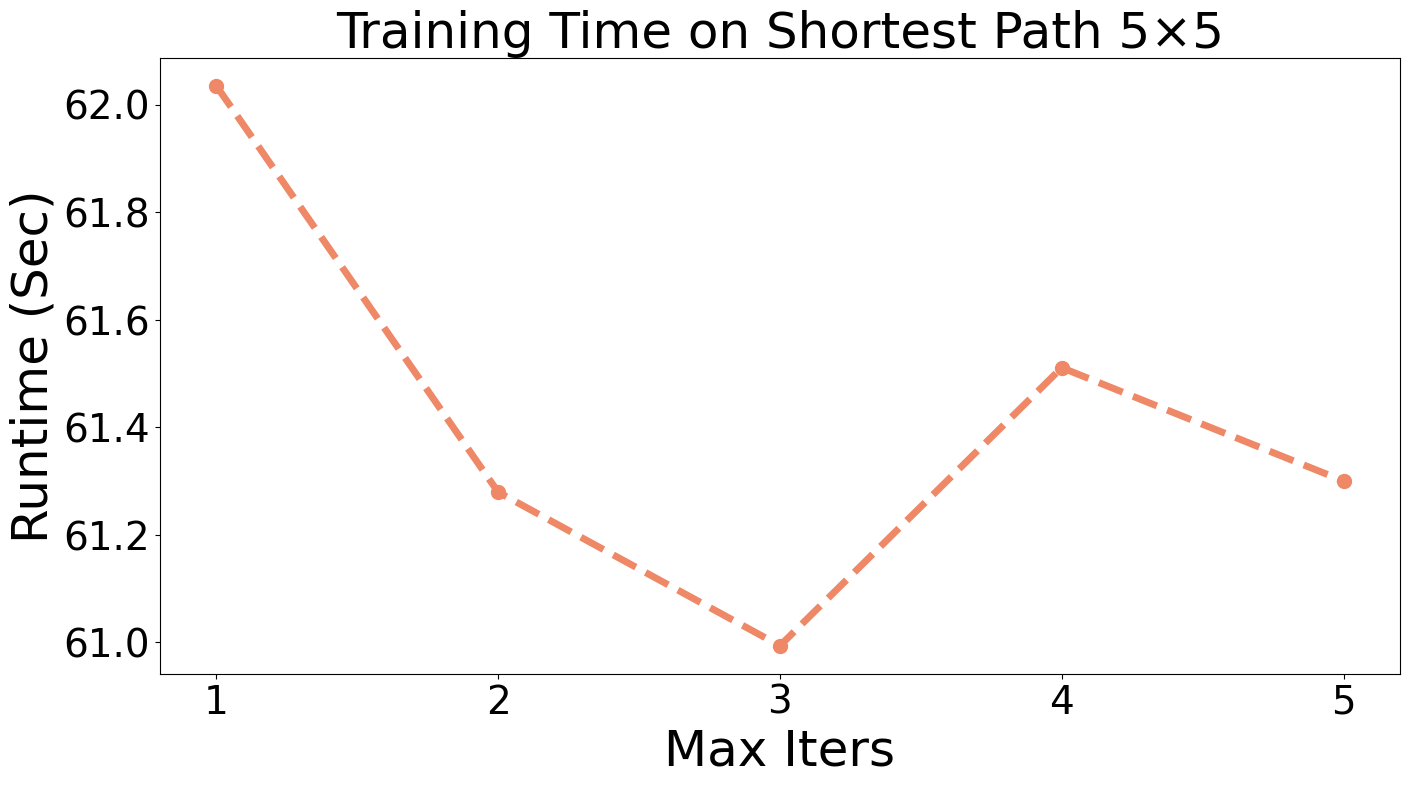

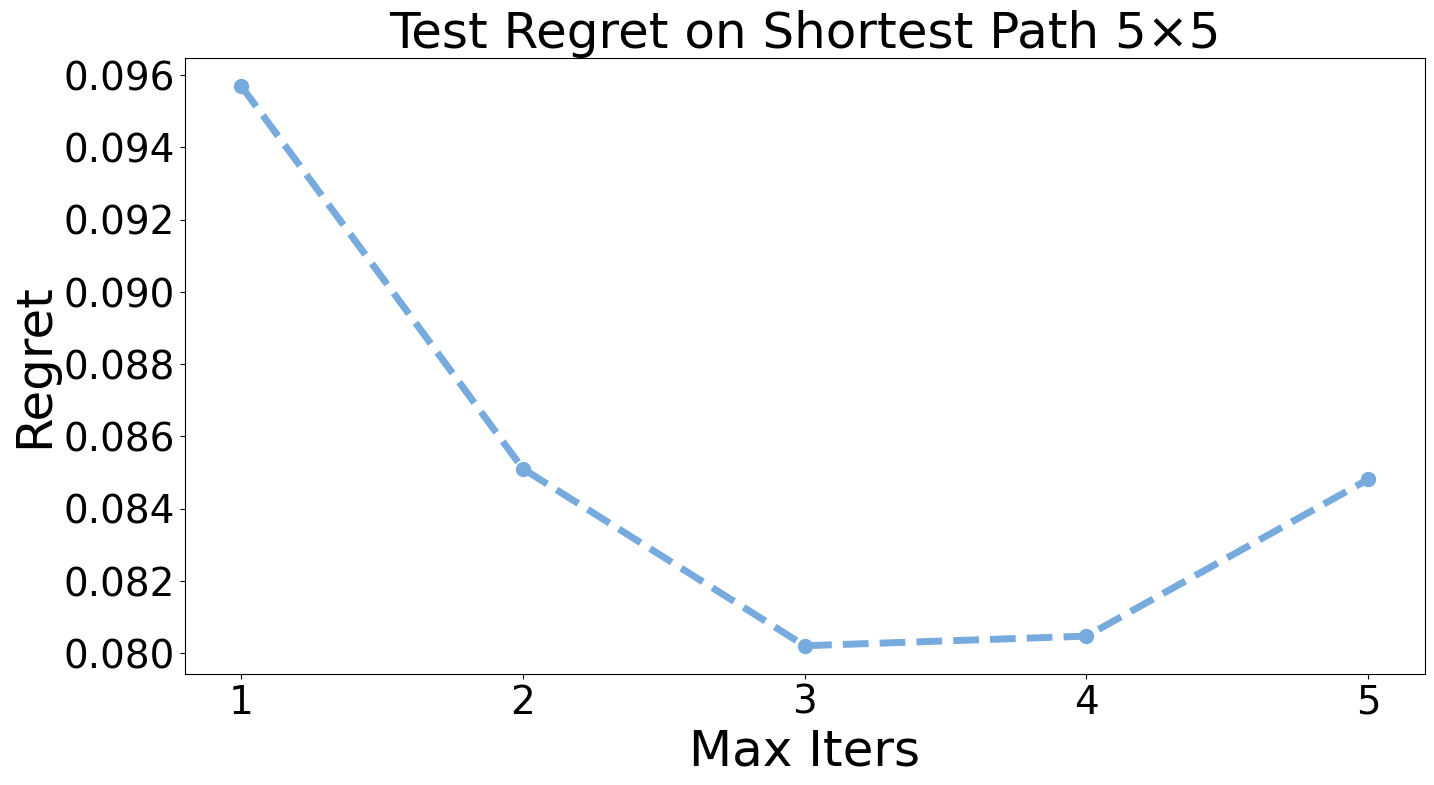

In [11]:
plot(max_iters, elapseds, regrets, "Shortest Path 5×5")

### TSP20

In [12]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+1000, num_feat, num_node, deg, e, seed=42)

In [13]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Obj: 57.6036
0 -> 5 -> 8 -> 10 -> 4 -> 12 -> 1 -> 17 -> 3 -> 16 -> 9 -> 18 -> 7 -> 2 -> 11 -> 13 -> 19 -> 6 -> 14 -> 15 -> 0


In [14]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.27it/s]


In [15]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [16]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out
    
# init model
reg = LinearRegression()

In [17]:
elapseds, regrets = pipeline(reg, optmodel, loader_train, loader_test)

Max Iter: 1
Num of cores: 1


Loss:  -0.9278: 100%|██████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.38s/it]


Test Regret: 8.9040%
Test Elapsed Time: 73.75 Sec

Max Iter: 2
Num of cores: 1


Loss:  -0.9825: 100%|██████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.45s/it]


Test Regret: 6.8465%
Test Elapsed Time: 74.51 Sec

Max Iter: 3
Num of cores: 1


Loss:  -0.9945: 100%|██████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.61s/it]


Test Regret: 6.4659%
Test Elapsed Time: 76.08 Sec

Max Iter: 4
Num of cores: 1


Loss:  -0.9981: 100%|██████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.56s/it]


Test Regret: 6.3993%
Test Elapsed Time: 75.61 Sec

Max Iter: 5
Num of cores: 1


Loss:  -0.9992: 100%|██████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.70s/it]


Test Regret: 6.7559%
Test Elapsed Time: 76.99 Sec



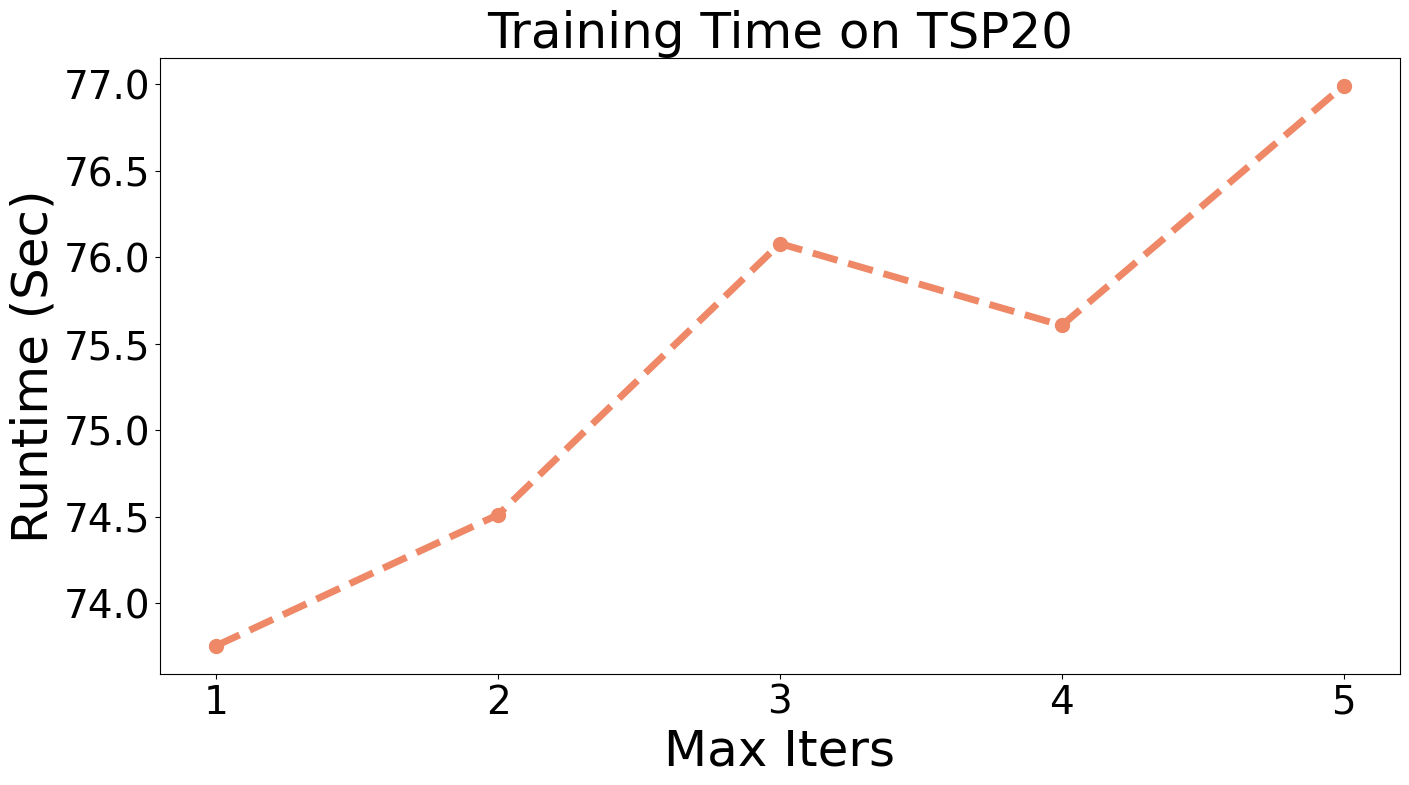

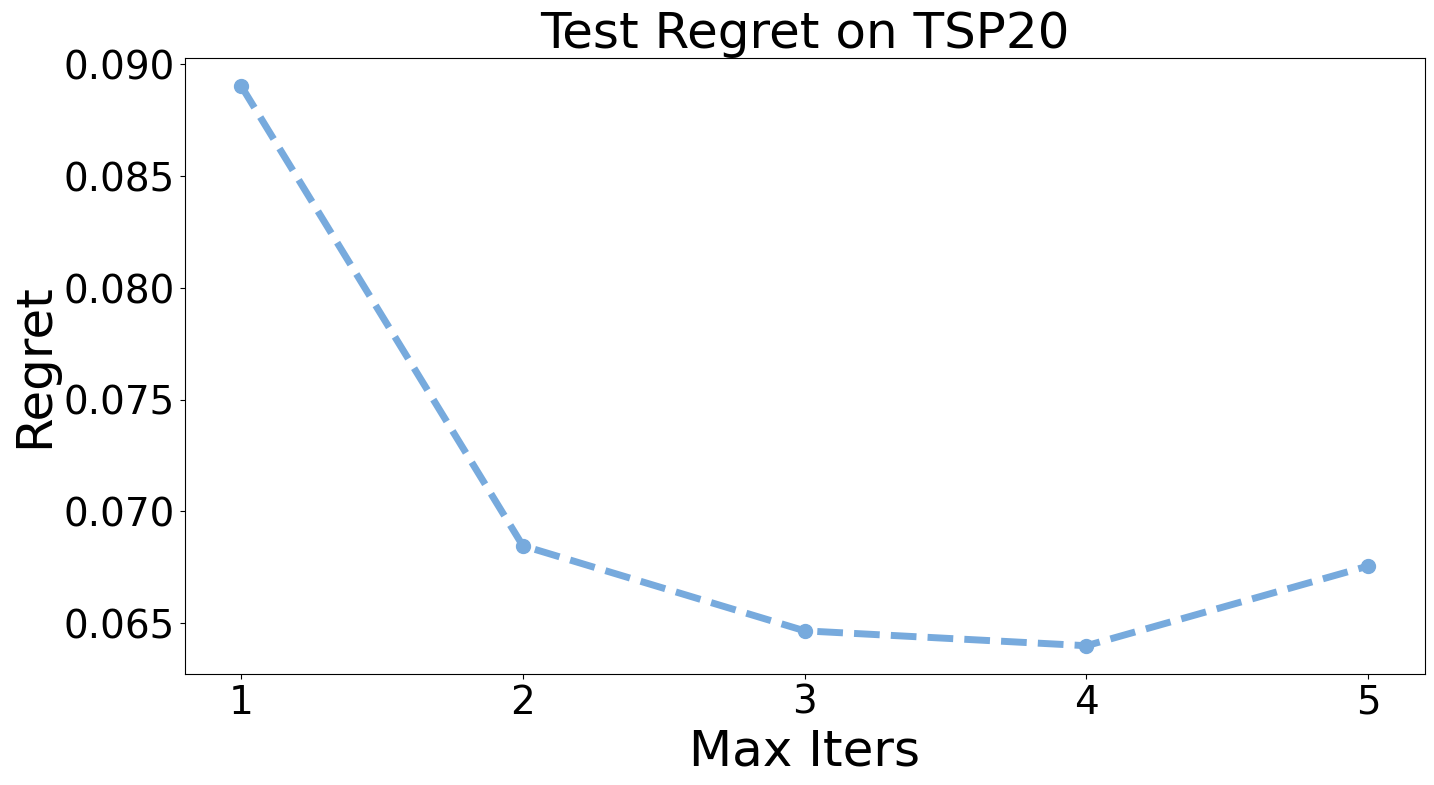

In [18]:
plot(max_iters, elapseds, regrets, "TSP20")

### TSP50

In [19]:
# generate data
num_node = 50 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+1000, num_feat, num_node, deg, e, seed=42)

In [20]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Obj: 84.4678
0 -> 16 -> 21 -> 42 -> 3 -> 5 -> 8 -> 13 -> 7 -> 18 -> 36 -> 2 -> 27 -> 47 -> 11 -> 20 -> 23 -> 22 -> 9 -> 25 -> 46 -> 19 -> 6 -> 14 -> 24 -> 44 -> 26 -> 43 -> 45 -> 39 -> 29 -> 48 -> 40 -> 1 -> 12 -> 41 -> 30 -> 10 -> 15 -> 17 -> 37 -> 32 -> 34 -> 49 -> 33 -> 35 -> 4 -> 31 -> 28 -> 38 -> 0


In [21]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:37<00:00,  4.59it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.38it/s]


In [22]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [23]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out
    
# init model
reg = LinearRegression()

In [24]:
elapseds, regrets = pipeline(reg, optmodel, loader_train, loader_test)

Max Iter: 1
Num of cores: 1


Loss:  -0.9295: 100%|██████████████████████████████████████████████████████████████████| 10/10 [08:56<00:00, 53.67s/it]


Test Regret: 12.8341%
Test Elapsed Time: 536.77 Sec

Max Iter: 2
Num of cores: 1


Loss:  -0.9830: 100%|██████████████████████████████████████████████████████████████████| 10/10 [08:37<00:00, 51.71s/it]


Test Regret: 9.8114%
Test Elapsed Time: 517.14 Sec

Max Iter: 3
Num of cores: 1


Loss:  -0.9949: 100%|██████████████████████████████████████████████████████████████████| 10/10 [08:36<00:00, 51.61s/it]


Test Regret: 7.9277%
Test Elapsed Time: 516.16 Sec

Max Iter: 4
Num of cores: 1


Loss:  -0.9983: 100%|██████████████████████████████████████████████████████████████████| 10/10 [08:35<00:00, 51.52s/it]


Test Regret: 7.4738%
Test Elapsed Time: 515.20 Sec

Max Iter: 5
Num of cores: 1


Loss:  -0.9994: 100%|██████████████████████████████████████████████████████████████████| 10/10 [09:08<00:00, 54.83s/it]


Test Regret: 7.6196%
Test Elapsed Time: 548.37 Sec



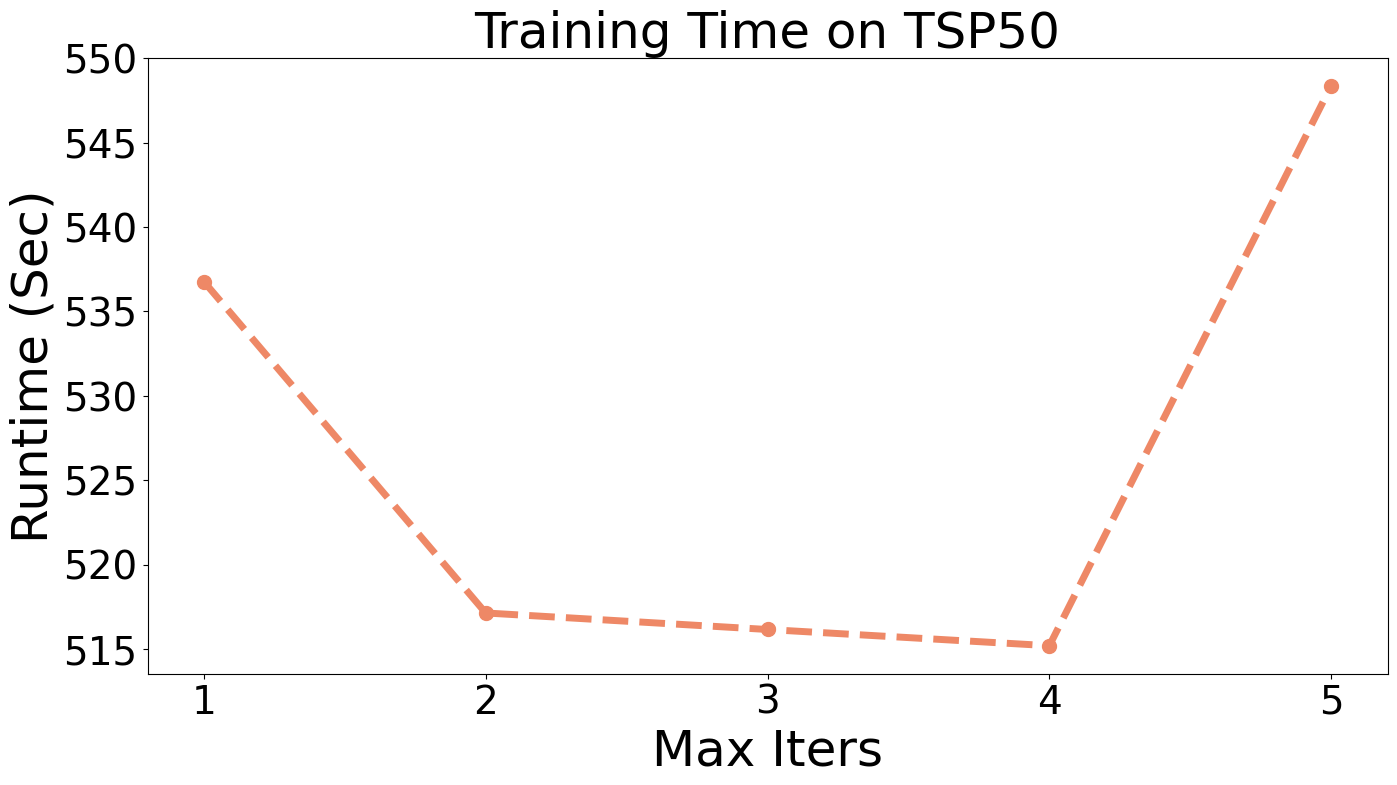

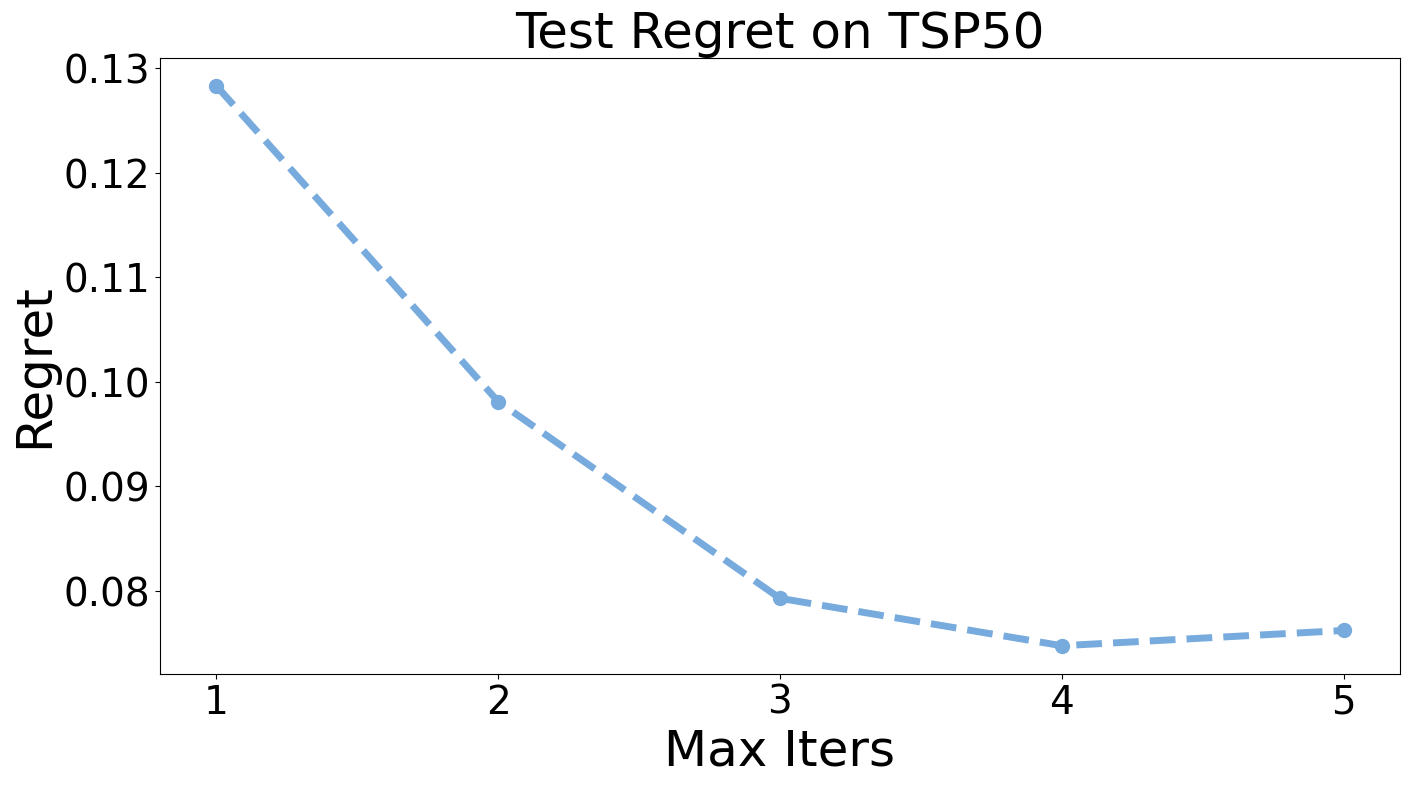

In [25]:
plot(max_iters, elapseds, regrets, "TSP50")